In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt 
import numpy as np
import baum_welch as bw
import cml_incomplete as cml_inc
import create_sequence_w_labels as cswl
from initial_guess import get_initial_values 


In [2]:
def viterbi(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
    result = []
    for s in S:
        result.append(s)
    return result


In [3]:
def combined_cml_approach(A, A_gt, B, B_gt, P, P_gt, pi, teoretical_observations, teoretical_labels, max_total_epoch, T_train, alternate_iter, K):
    prob_list_total = []
    for i in range(max_total_epoch):
        # Update A and P using the cml with incomplete label approach
        A, B, P = cml_inc.fit(A, B, P, pi, teoretical_observations[0:T_train], teoretical_labels[0:T_train], alternate_iter, update_A=True, update_B=False, update_P=True)
        
        # Update B and pi
        A, B, pi, prob_list, iter, final_tolerance = bw.fit(A, B, teoretical_observations[0:T_train], K, TOL = 1e-5, NUM_ITER = alternate_iter, pi = pi, hold_A=True)
        
        for j in range(len(prob_list)):
            prob_list_total.append(prob_list[j])
        print('Total epoch:', i)

    print('A_final:\n', np.round(A,3))
    print('A_gt:\n', A_gt)
    print('diff_A:', np.linalg.norm(A - A_gt))
    print('B_final:\n', np.round(B,3))
    print('B_gt:\n', B_gt)
    print('diff_B:', np.linalg.norm(B - B_gt))
    print('P_final:\n', np.round(P,3))
    print('P_gt:\n', np.round(P_gt,3))
    print('diff_P:', np.linalg.norm(P - P_gt))
    plt.plot(prob_list_total)
    plt.show()
    print('The best probability we can get on the combined CML appraoch is:', prob_list_total[-1])
    return A, B, pi

In [4]:
def pure_bw_approach(A, A_gt, B, B_gt, teoretical_observations, K, alternate_iter, pi):
    A, B, pi, prob_list, _, _ = bw.fit(A, B, teoretical_observations[0:T_train], K, TOL = 1e-5, NUM_ITER = alternate_iter, pi = pi, hold_A = False)
    print('A_final:\n', np.round(A,3))
    print('A_gt:\n', A_gt)
    print('diff_A:', np.linalg.norm(A - A_gt))
    print('B_final:\n', np.round(B,3))
    print('B_gt:\n', B_gt)
    print('diff_B:', np.linalg.norm(B - B_gt))
    plt.plot(prob_list)
    plt.show()
    print('The best probability we can get on the pure BW appraoch is:', prob_list[-1])
    return A, B, pi

In [5]:
def calculate_wrong_prediction(T_dev, T_train, teoretical_observations, teoretical_states, A_final_cml, B_final_cml, pi_final_cml, A_final_bw, B_final_bw, pi_final_bw):
    wrong_estimates_bw_total = 0
    wrong_estimates_cml_total = 0
    for dev_index in range(T_dev):
        result_cml = viterbi(np.array(teoretical_observations[T_train+dev_index]), A_final_cml, B_final_cml, pi_final_cml.T)
        result_bw = viterbi(np.array(teoretical_observations[T_train+dev_index]), A_final_bw, B_final_bw, pi_final_bw.T)
        wrong_estimates_cml = 0
        wrong_estimates_bw = 0
        for m in range(len(result_cml)):
            if result_cml[m] != teoretical_states[T_train+dev_index][m]:
                wrong_estimates_cml += 1
            if result_bw[m] != teoretical_states[T_train+dev_index][m]:
                wrong_estimates_bw += 1 
        wrong_estimates_bw_total += wrong_estimates_bw/N*100
        wrong_estimates_cml_total += wrong_estimates_cml/N*100
    
    wrong_estimates_cml_mean = np.round(wrong_estimates_cml_total/T_dev,4)
    wrong_estimates_bw_mean = np.round(wrong_estimates_bw_total/T_dev,4)
    cml_better = -np.round(wrong_estimates_cml_mean - wrong_estimates_bw_mean, 4)

    print('The percentage of the wrong estimated states for the combained cml appraoch in average is:', wrong_estimates_cml_mean)
    print('The percentage of the wrong estimated states for the bw appraoch in average is:', wrong_estimates_bw_mean)
    print('The cml in average is ' + str(cml_better) + ' better than the BW')

0
1
2
Total epoch: 0
0
1
2
Total epoch: 1
0
1
2
Total epoch: 2
0
1
2
Total epoch: 3
0
1
2
Total epoch: 4
A_final:
 [[0.402 0.598]
 [0.606 0.394]]
A_gt:
 [[0.491 0.509]
 [0.744 0.256]]
diff_A: 0.23185499297526743
B_final:
 [[0.546 0.008 0.179 0.267]
 [0.09  0.142 0.172 0.596]]
B_gt:
 [[0.441 0.073 0.186 0.3  ]
 [0.145 0.075 0.156 0.624]]
diff_B: 0.1581772597532011
P_final:
 [[0.714 0.    0.286]
 [0.    0.731 0.269]]
P_gt:
 [[0.606 0.    0.394]
 [0.    0.894 0.106]]
diff_P: 0.27571321679913435


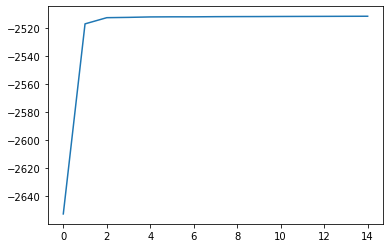

The best probability we can get on the combined CML appraoch is: -2511.7241055974387
A_final:
 [[0.529 0.471]
 [0.714 0.286]]
A_gt:
 [[0.491 0.509]
 [0.744 0.256]]
diff_A: 0.06933185779300888
B_final:
 [[0.468 0.032 0.183 0.317]
 [0.095 0.139 0.164 0.602]]
B_gt:
 [[0.441 0.073 0.186 0.3  ]
 [0.145 0.075 0.156 0.624]]
diff_B: 0.09888003057738466


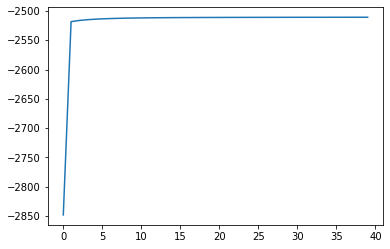

The best probability we can get on the pure BW appraoch is: -2510.771876246113
0
1
2
Total epoch: 0
0
1
2
Total epoch: 1
0
1
2
Total epoch: 2
0
1
2
Total epoch: 3
0
1
2
Total epoch: 4
A_final:
 [[0.338 0.662]
 [0.528 0.472]]
A_gt:
 [[0.346 0.654]
 [0.537 0.463]]
diff_A: 0.01713413049273854
B_final:
 [[0.252 0.295 0.06  0.392]
 [0.3   0.136 0.404 0.16 ]]
B_gt:
 [[0.225 0.288 0.062 0.425]
 [0.325 0.138 0.404 0.133]]
diff_B: 0.056684798911906344
P_final:
 [[0.885 0.    0.115]
 [0.    0.801 0.199]]
P_gt:
 [[0.879 0.    0.121]
 [0.    0.809 0.191]]
diff_P: 0.013930878754390873


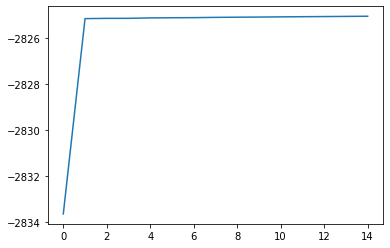

The best probability we can get on the combined CML appraoch is: -2825.0511997292137
A_final:
 [[0.276 0.724]
 [0.505 0.495]]
A_gt:
 [[0.346 0.654]
 [0.537 0.463]]
diff_A: 0.10907517015719188
B_final:
 [[0.229 0.306 0.066 0.399]
 [0.314 0.137 0.381 0.168]]
B_gt:
 [[0.225 0.288 0.062 0.425]
 [0.325 0.138 0.404 0.133]]
diff_B: 0.053843772969054494


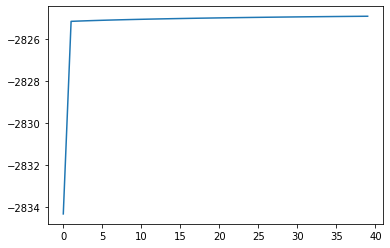

The best probability we can get on the pure BW appraoch is: -2824.9089952512277
0
1
2
Total epoch: 0
0
1
2
Total epoch: 1
0
1
2
Total epoch: 2
0
1
2
Total epoch: 3
0


In [6]:
K = 2                  # states
L = 4                  # observations
T_train = 15           # number of training sequences 
T_dev = 10             # number of development set sequences
T = T_train + T_dev    # total number of sequences
N = 2048               # number of observations on each sequence
noise_variance = 0.1   # Noise variance
alternate_iter = 3     # alternate the update of A and P after 'alternate_iter' iterations with B and pi
max_total_epoch = 5    # Do the update of A and P and B and pi respectively max_total_epoch times 
                       # where each iteration of A/B/P/pi is alternate_iter times
bw_iter = 40           # Max iterate for tthe pure baum-welch approach 
do_experiment = 5      

for i in range(do_experiment):
    A_gt, B_gt, pi_gt, P_gt, teoretical_observations, teoretical_states, teoretical_labels = cswl.hmmgenerate(K, L, T, N, S=0, D=0, edhmm = False)
    A_init, B_init, pi_init, P_init = get_initial_values(A_gt, B_gt, noise_variance, P_gt, have_P = True)
    A_final_cml, B_final_cml, pi_final_cml = combined_cml_approach(A_init, A_gt, B_init, B_gt, P_init, P_gt, pi_init, teoretical_observations, teoretical_labels, max_total_epoch, T_train, alternate_iter, K)
    A_final_bw, B_final_bw, pi_final_bw = pure_bw_approach(A_init, A_gt, B_init, B_gt, teoretical_observations, K, bw_iter, pi_init)
    #calculate_wrong_prediction(T_dev, T_train, teoretical_observations, teoretical_states, A_final_cml, B_final_cml, pi_final_cml, A_final_bw, B_final_bw, pi_final_bw)
